# Desafio 2 Grupo 7

## Regresión Lineal Múltiple <br> Modelos regularizados (Ridge y Lasso) y sin regularizar <br> 



Integrantes:



> Albano Remonda

> Jesica Milloch

> Sebastian Salvarezza

> Ezequiel Tokman

> Nicolas Ramos

### Introducción

En el siguiente trabajo vamos a intentar crear una regresión lineal múltiple utilizando los datos de la base de datos de Properatti. <br>
En el mismo, intentaremos predecir el precio por metro cuadrado de las propiedades múltiples barrios de CABA y algunos de zona norte, a partir de un conjunto de variables dummies y algunas numéricas, como la cantidad de habitaciones, superficie descubierta y superficie total.

Los datos con los que vamos a trabajar fueron previamente trabajados. En particular, las transformaciones y limpieza de datos más relevantes que realizamos son:
- Completamos la columna _rooms_ extrayendo con Regex de la columna _description_.
- Eliminamos outliers, utilizando rangos intercuartiles.
- Seleccionamos los barrios en cuestión a partir de la columna _place_name_.
- Creamos nuevas columnas que transformaremos a _dummies_, determinando si la propiedad en cuestión tiene piscina, balcon, estacionamiento, si es a estrenar, si tiene subte, metrobus, o tren cerca, y si cuenta con seguridad.
- Calculamos la superficie descubierta de cada propiedad.

### Limpieza final

In [1]:
# Importamos librerías a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import io
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tools import eval_measures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Importamos el dataset 

data = pd.read_csv("../Data/datos_input_tp2_2.csv", sep=",")
data.head(1)

,Unnamed: 0,Unnamed: 0.1,surface_covered_in_m2,price_usd_per_m2,surface_total_in_m2,rooms,description,property_type,place_name,parking,...,balcon,seguridad,subte,metrobus,tren,gimnasio,parque,surface_uncovered,ambientes2,place_name_house
0,2,12,36.0,2948.717949,39.0,2.0,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...,apartment,Martínez,False,...,False,False,False,False,False,False,False,3.0,2,Martínez apartment


Renombramos la columna de precio por m2 para trabajar más cómodos

In [3]:
data.rename(columns = {'price_usd_per_m2':'price_m2'}, inplace = True)

Las columnas con las que vamos a trabajar son las siguientes.

In [4]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'surface_covered_in_m2', 'price_m2',
       'surface_total_in_m2', 'rooms', 'description', 'property_type',
       'place_name', 'parking', 'piscina', 'a_estrenar', 'balcon', 'seguridad',
       'subte', 'metrobus', 'tren', 'gimnasio', 'parque', 'surface_uncovered',
       'ambientes2', 'place_name_house'],
      dtype='object')

Con el histograma obsevamos que el grueso de las observaciones de los datos que tomamos tienen un precio por metro cuadrado que oscila mayoritariamente entre 1000 y 5000.

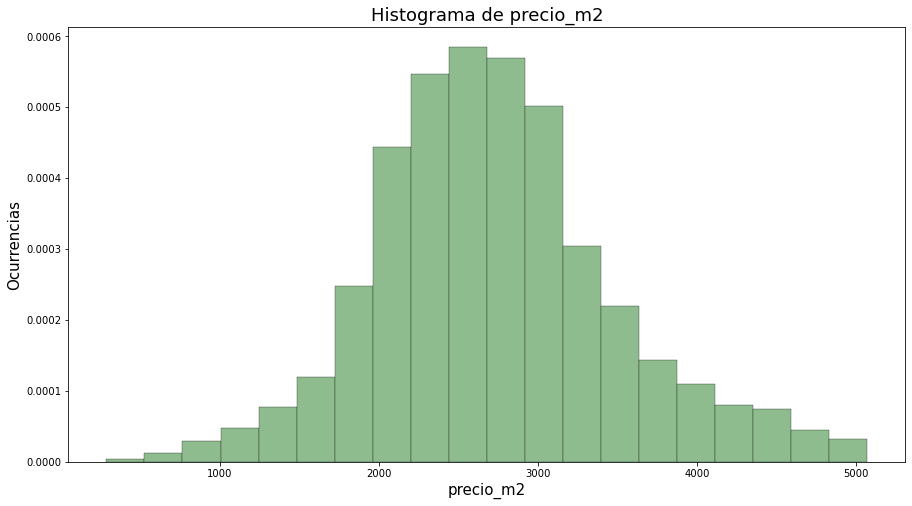

In [5]:
fig = plt.figure(figsize = (15,8))
plt.hist(data.price_m2, bins=20, color='darkseagreen',density=True, edgecolor="black", linewidth = .3)
plt.title('Histograma de precio_m2', fontsize=18)
plt.xlabel('precio_m2', fontsize=15)
plt.ylabel('Ocurrencias', fontsize=15)
plt.show()

In [6]:
data.price_m2.describe()

count    7653.000000
mean     2729.288822
std       757.623465
min       288.888889
25%      2234.424545
50%      2671.232877
75%      3138.461538
max      5068.493151
Name: price_m2, dtype: float64

Vemos que antes de comenzar a trabajar tenemos que hacer una limpieza de datos nulos, para las columnas _surface_covered_in_m2_, 
_surface_uncovered_, y _ambientes2_ (esta última es una columna auxiliar para mejorar la columna de _rooms_).

In [7]:
# Chequeamos los nulos

print(data.isnull().sum())
print(data.shape)

Unnamed: 0                  0
Unnamed: 0.1                0
surface_covered_in_m2     195
price_m2                    0
surface_total_in_m2         0
rooms                       0
description                 0
property_type               0
place_name                  0
parking                     0
piscina                     0
a_estrenar                  0
balcon                      0
seguridad                   0
subte                       0
metrobus                    0
tren                        0
gimnasio                    0
parque                      0
surface_uncovered         195
ambientes2               1076
place_name_house            0
dtype: int64
(7653, 22)


In [8]:
# Limpiamos la columna ambientes2 

data.drop(columns=['ambientes2'],inplace=True)

In [9]:
# Limpiamos los nulos

data = data.dropna()

In [10]:
# Volvemos a chequear que no tengamos más nulos

print(data.isnull().sum())
print(data.shape)

Unnamed: 0               0
Unnamed: 0.1             0
surface_covered_in_m2    0
price_m2                 0
surface_total_in_m2      0
rooms                    0
description              0
property_type            0
place_name               0
parking                  0
piscina                  0
a_estrenar               0
balcon                   0
seguridad                0
subte                    0
metrobus                 0
tren                     0
gimnasio                 0
parque                   0
surface_uncovered        0
place_name_house         0
dtype: int64
(7458, 21)


In [11]:
properties = data.property_type.value_counts()
properties = pd.DataFrame(properties)
cantidades_properties = properties.property_type
properties_index = (properties.index).tolist()
properties_cantidades = (properties.values).tolist()
properties_values = (properties.property_type).tolist()
properties

,property_type
apartment,7012
house,446


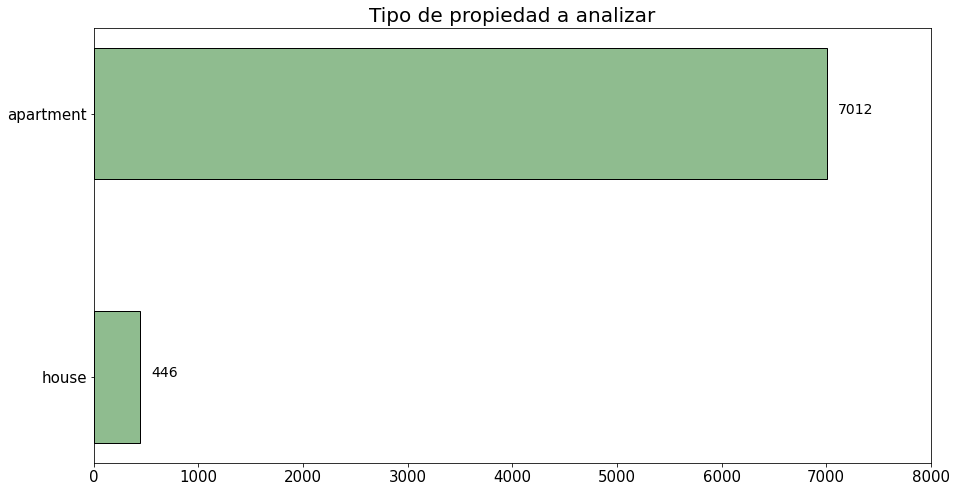

In [12]:
fig = plt.figure(figsize = (15,8))
ax = plt.axes()
width=0.5
labels= properties_values

x = np.arange(len(properties_index))
y = (properties_values)

ax.set_yticks(x)
ax.set_yticklabels(properties_index,fontsize=15)
ax.set_xticks(y)
ax.set_xticklabels(y,fontsize=15)
ax.set_xlim(0,1)
ax.set_title('Tipo de propiedad a analizar', fontsize = 20)

x_ticks = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
plt.xticks(ticks=x_ticks, labels=x_ticks)
bars = ax.barh(x, y, width, data = properties, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()#

for i, v in enumerate(y):
    ax.text(v+100, i, str(v), fontsize=14)
plt.show()

In [13]:
barrios = data.place_name.value_counts()
barrios = pd.DataFrame(barrios)
cantidades = barrios.place_name
barrios_index = (barrios.index).tolist()
barrios_cantidades = (barrios.values).tolist()
barrios_values = (barrios.place_name).tolist()

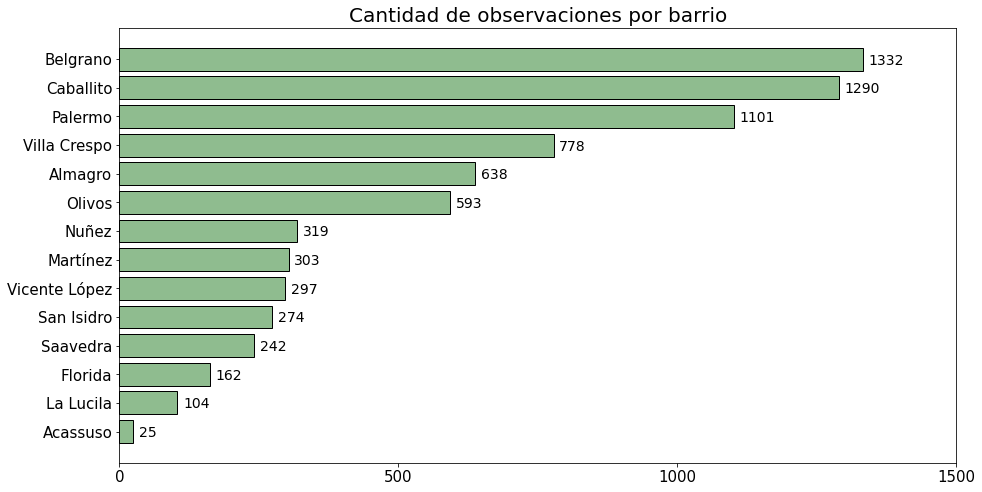

In [14]:
fig = plt.figure(figsize = (15, 8))
ax = plt.axes()
width=0.8
labels= barrios_values

x = np.arange(len(barrios_index))
y = (barrios_values)

ax.set_yticks(x)
ax.set_yticklabels(barrios_index,fontsize=15)
ax.set_xticks(y)
ax.set_xticklabels(y,fontsize=15)
ax.set_xlim(0,1)
ax.set_title('Cantidad de observaciones por barrio', fontsize = 20)

x_ticks = [0, 500,1000, 1500]
plt.xticks(ticks=x_ticks, labels=x_ticks)
bars = ax.barh(x, y, width, data = barrios, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()#

for i, v in enumerate(y):
    ax.text(v+10, i +.18, str(v), fontsize=14)
plt.show()

Vemos cómo nos queda un dataset de 7458 filas

### Análisis exploratorio

Realizamos algunos gráficos para entender los datos con los que estamos trabajando:
- Porcentaje de nuestros datos que cumplen con cada atributo / feature.
- Cantidad de propiedades según rango de precios por metro cuadrado.

In [15]:
parking_percentage = data.parking.value_counts() / len(data)
piscina_percentage = data.piscina.value_counts() / len(data)
a_estrenar_percentage = data.a_estrenar.value_counts() / len(data)
balcon_percentage = data.balcon.value_counts() / len(data)
seguridad_percentage = data.seguridad.value_counts() / len(data)
subte_percentage = data.subte.value_counts() / len(data)
metrobus_percentage = data.metrobus.value_counts() / len(data)
tren_percentage = data.tren.value_counts() / len(data)
gimnasio_percentage = data.gimnasio.value_counts() / len(data)
parque_percentage = data.parque.value_counts() / len(data)


parking_values = [parking_percentage.values.tolist()]
piscina_values = [piscina_percentage.values.tolist()]
a_estrenar_values = [a_estrenar_percentage.values.tolist()]
balcon_values = [balcon_percentage.values.tolist()]
seguridad_values = [seguridad_percentage.values.tolist()]
subte_values = [subte_percentage.values.tolist()]
metrobus_values = [metrobus_percentage.values.tolist()]
tren_values = [tren_percentage.values.tolist()]
gimnasio_values = [gimnasio_percentage.values.tolist()]
parque_values = [parque_percentage.values.tolist()]



falsos = [parking_percentage.loc[parking_percentage.index is False], 
          piscina_percentage.loc[piscina_percentage.index is False], 
          a_estrenar_percentage.loc[a_estrenar_percentage.index is False],
         balcon_percentage.loc[balcon_percentage.index is False],
         seguridad_percentage.loc[seguridad_percentage.index is False],
         subte_percentage.loc[subte_percentage.index is False],
         metrobus_percentage.loc[metrobus_percentage.index is False],
         tren_percentage.loc[tren_percentage.index is False],
         gimnasio_percentage.loc[gimnasio_percentage.index is False],
         parque_percentage.loc[parque_percentage.index is False]]

verdaderos = [parking_percentage.loc[parking_percentage.index is not False], 
          piscina_percentage.loc[piscina_percentage.index is not False], 
          a_estrenar_percentage.loc[a_estrenar_percentage.index is not False],
          balcon_percentage.loc[balcon_percentage.index is not False],
          seguridad_percentage.loc[seguridad_percentage.index is not False],
          subte_percentage.loc[subte_percentage.index is not False],
          metrobus_percentage.loc[metrobus_percentage.index is not False],
          tren_percentage.loc[tren_percentage.index is not False],
          gimnasio_percentage.loc[gimnasio_percentage.index is not False],
          parque_percentage.loc[parque_percentage.index is not False]]


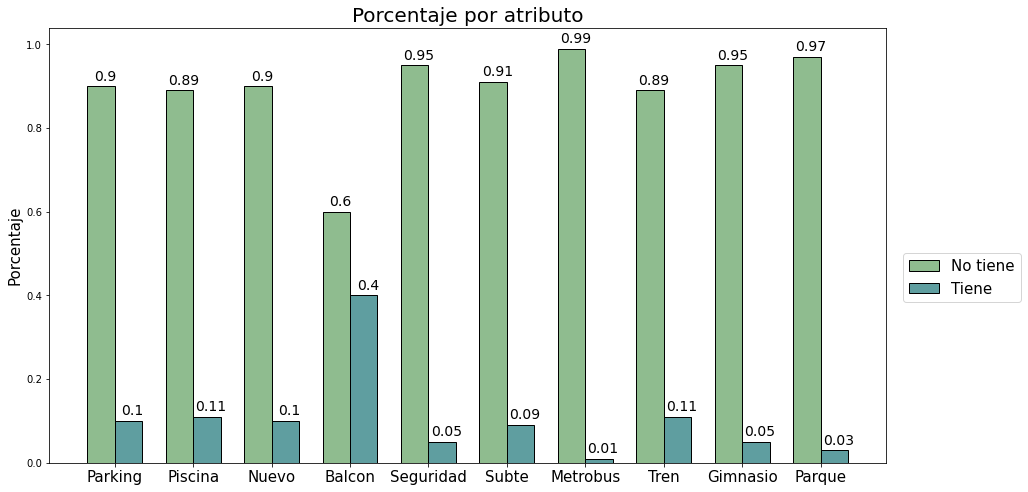

In [16]:
# Graficamos

labels = ['Parking', 'Piscina', 'Nuevo',"Balcon","Seguridad","Subte","Metrobus","Tren", "Gimnasio", "Parque"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x - width/2, np.round(falsos,2), width, label='No tiene', color="darkseagreen",edgecolor="black")
rects2 = ax.bar(x + width/2, np.round(verdaderos,2), width, label='Tiene', color="cadetblue", edgecolor="black")

ax.set_ylabel('Porcentaje', fontsize=15)
ax.set_title('Porcentaje por atributo',fontsize=20)
ax.set_xticks(x)
y_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
ax.set_yticks(ticks=y_ticks)
ax.set_xticklabels(labels, fontsize=15)
ax.legend(["No tiene", "Tiene"],fontsize=15, bbox_to_anchor=(1.17, 0.5))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(4, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=14)

autolabel(rects1)
autolabel(rects2)

In [17]:
data['rango_precios'] = np.where(data['price_m2']<1000, 'Hasta 1.000 USD',
                   np.where(data['price_m2']<2000, 'Entre 1.000 USD y 2.000 USD',
                   np.where(data['price_m2']<3000, 'Entre 2.000 USD y 3.000 USD',
                   np.where(data['price_m2']<4000, 'Entre 3.000 USD y 4.000 USD',
                   np.where(data['price_m2']<5000, 'Entre 4.000 USD y 5.000 USD',
                   np.where(data['price_m2']<6000, 'Entre 5.000 USD y 6.000 uSD', 'Mayor a 6.000 USD'))))))

In [18]:
rango_precios = data.rango_precios.value_counts()
rango_precios_keys = (rango_precios.index).tolist()
rango_precios_values = (rango_precios.values).tolist()
rango_precios = pd.DataFrame(rango_precios)
rango_precios["rango"] = rango_precios.index
rango_precios_keys

['Entre 2.000 USD y 3.000 USD',
 'Entre 3.000 USD y 4.000 USD',
 'Entre 1.000 USD y 2.000 USD',
 'Entre 4.000 USD y 5.000 USD',
 'Hasta 1.000 USD',
 'Entre 5.000 USD y 6.000 uSD']

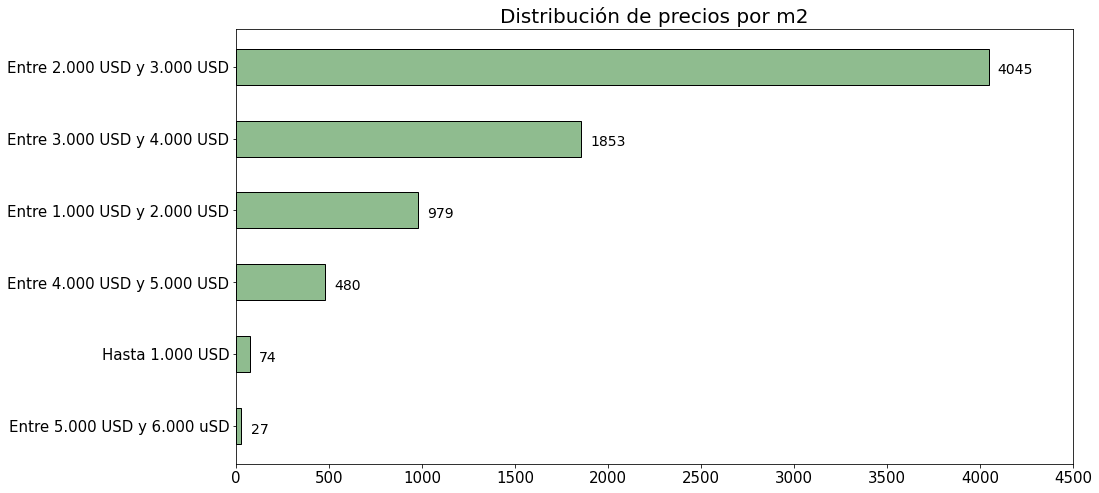

In [19]:
fig = plt.figure(figsize = (15, 8))
ax = plt.axes()
width=0.5
labels= rango_precios_values

x = np.arange(len(rango_precios_keys))
y = (rango_precios_values)

ax.set_yticks(x)
ax.set_yticklabels(rango_precios_keys,fontsize=15)
ax.set_xticks(y)
ax.set_xticklabels(y,fontsize=15)
ax.set_xlim(0,1)
ax.set_title('Distribución de precios por m2', fontsize = 20)

x_ticks = [0, 500,1000, 1500, 2000, 2500,3000,3500,4000, 4500]
plt.xticks(ticks=x_ticks, labels=x_ticks)
bars = ax.barh(x, y, width, data = rango_precios, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+50, i +.1, str(v), fontsize=14)
plt.show()

### Generación de dummies

Generamos las dummies necesarias para trabajar con los datos.

In [20]:
data_dummies = pd.get_dummies(data, columns = ['piscina',"balcon","a_estrenar","parking","property_type","seguridad","subte","metrobus","tren","place_name_house", "place_name","gimnasio","parque"])
data_dummies.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'surface_covered_in_m2', 'price_m2',
       'surface_total_in_m2', 'rooms', 'description', 'surface_uncovered',
       'rango_precios', 'piscina_False', 'piscina_True', 'balcon_False',
       'balcon_True', 'a_estrenar_False', 'a_estrenar_True', 'parking_False',
       'parking_True', 'property_type_apartment', 'property_type_house',
       'seguridad_False', 'seguridad_True', 'subte_False', 'subte_True',
       'metrobus_False', 'metrobus_True', 'tren_False', 'tren_True',
       'place_name_house_Acassuso apartment',
       'place_name_house_Acassuso house', 'place_name_house_Almagro apartment',
       'place_name_house_Almagro house', 'place_name_house_Belgrano apartment',
       'place_name_house_Belgrano house',
       'place_name_house_Caballito apartment',
       'place_name_house_Caballito house',
       'place_name_house_Florida apartment', 'place_name_house_Florida house',
       'place_name_house_La Lucila apartment',
       'place_name_ho

Luego, extramos las columnas que necesitamos para el input del modelo. 

In [21]:
# Extraigo las columnas que necesitamos

data_casi_final = data_dummies[['surface_covered_in_m2', 'price_m2',
       'surface_total_in_m2', 'rooms', 'description', 'surface_uncovered',
       'rango_precios', 'piscina_False', 'piscina_True', 'balcon_False',
       'balcon_True', 'a_estrenar_False', 'a_estrenar_True', 'parking_False',
       'parking_True', 'property_type_apartment', 'property_type_house',
       'seguridad_False', 'seguridad_True', 'subte_False', 'subte_True',
       'metrobus_False', 'metrobus_True', 'tren_False', 'tren_True',"gimnasio_True","parque_True",
       'place_name_house_Acassuso apartment',
       'place_name_house_Acassuso house', 'place_name_house_Almagro apartment',
       'place_name_house_Almagro house', 'place_name_house_Belgrano apartment',
       'place_name_house_Belgrano house',
       'place_name_house_Caballito apartment',
       'place_name_house_Caballito house',
       'place_name_house_Florida apartment', 'place_name_house_Florida house',
       'place_name_house_La Lucila apartment',
       'place_name_house_La Lucila house',
       'place_name_house_Martínez apartment',
       'place_name_house_Martínez house', 'place_name_house_Nuñez apartment',
       'place_name_house_Nuñez house', 'place_name_house_Olivos apartment',
       'place_name_house_Olivos house', 'place_name_house_Palermo apartment',
       'place_name_house_Palermo house', 'place_name_house_Saavedra apartment',
       'place_name_house_Saavedra house',
       'place_name_house_San Isidro apartment',
       'place_name_house_San Isidro house',
       'place_name_house_Vicente López apartment',
       'place_name_house_Vicente López house',
       'place_name_house_Villa Crespo apartment',
       'place_name_house_Villa Crespo house', 'place_name_Acassuso',
       'place_name_Almagro', 'place_name_Belgrano', 'place_name_Caballito',
       'place_name_Florida', 'place_name_La Lucila', 'place_name_Martínez',
       'place_name_Nuñez', 'place_name_Olivos', 'place_name_Palermo',
       'place_name_Saavedra', 'place_name_San Isidro',
       'place_name_Vicente López', 'place_name_Villa Crespo']]

Ahora, normalizamos las variables numéricas, utilizando el método Min Max:
- _rooms_.
- _surface_covered_in_m2_.
- _surface_uncovered_.

In [22]:
from sklearn import preprocessing

numericals = ["rooms", "surface_covered_in_m2","surface_uncovered"]
X = data[numericals]

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

nm_numerical_data = scaler.transform(X)
std_df = pd.DataFrame(nm_numerical_data)
std_df.columns = [i + "_nm" for i in numericals]

Luego, concatenamos las variables y obtenemos el input final del modelo.

In [23]:
# Concatenamos todo y generamos el dataset final

data_final = pd.concat([data_casi_final.reset_index(drop=True), std_df.reset_index(drop=True)],axis=1)
data_final.head(1)

,surface_covered_in_m2,price_m2,surface_total_in_m2,rooms,description,surface_uncovered,rango_precios,piscina_False,piscina_True,balcon_False,...,place_name_Nuñez,place_name_Olivos,place_name_Palermo,place_name_Saavedra,place_name_San Isidro,place_name_Vicente López,place_name_Villa Crespo,rooms_nm,surface_covered_in_m2_nm,surface_uncovered_nm
0,36.0,2948.717949,39.0,2.0,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...,3.0,Entre 2.000 USD y 3.000 USD,1,0,1,...,0,0,0,0,0,0,0,0.001297,0.008451,0.706355


In [24]:
data_final.columns

Index(['surface_covered_in_m2', 'price_m2', 'surface_total_in_m2', 'rooms',
       'description', 'surface_uncovered', 'rango_precios', 'piscina_False',
       'piscina_True', 'balcon_False', 'balcon_True', 'a_estrenar_False',
       'a_estrenar_True', 'parking_False', 'parking_True',
       'property_type_apartment', 'property_type_house', 'seguridad_False',
       'seguridad_True', 'subte_False', 'subte_True', 'metrobus_False',
       'metrobus_True', 'tren_False', 'tren_True', 'gimnasio_True',
       'parque_True', 'place_name_house_Acassuso apartment',
       'place_name_house_Acassuso house', 'place_name_house_Almagro apartment',
       'place_name_house_Almagro house', 'place_name_house_Belgrano apartment',
       'place_name_house_Belgrano house',
       'place_name_house_Caballito apartment',
       'place_name_house_Caballito house',
       'place_name_house_Florida apartment', 'place_name_house_Florida house',
       'place_name_house_La Lucila apartment',
       'place_name_

Ahora, corroboramos que no estamos trabajando con nulos y revisamos la shape final: 7458 observaciones

In [25]:
print(data_final.isnull().sum())
print(data_final.shape)

surface_covered_in_m2       0
price_m2                    0
surface_total_in_m2         0
rooms                       0
description                 0
                           ..
place_name_Vicente López    0
place_name_Villa Crespo     0
rooms_nm                    0
surface_covered_in_m2_nm    0
surface_uncovered_nm        0
Length: 72, dtype: int64
(7458, 72)


In [26]:
# data_final.to_csv('data_final.csv')

### Modelamos una regresión sin regularizar

Comenzamos con una regresión Lineal Múltiple sin regularizar <br> Asignamos en el objeto _X_ las variables explicativas, y en el objeto _y_ la variable a predecir, precio por metro cuadrado. <br> Luego definimos los datos de entrenamiento (75%) y de testeo (25%).

In [27]:
X = data_final[['piscina_True', 'balcon_True', 
       'a_estrenar_True', 'parking_True',
       'property_type_house',
       'seguridad_True', 'subte_True',
       'metrobus_True', 'tren_True', "gimnasio_True","parque_True",
       'place_name_Almagro', 'place_name_Belgrano', 'place_name_Caballito',
       'place_name_Florida', 'place_name_La Lucila', 'place_name_Martínez',
       'place_name_Nuñez', 'place_name_Olivos', 'place_name_Palermo',
       'place_name_Saavedra', 'place_name_San Isidro',
       'place_name_Vicente López', 'place_name_Villa Crespo', 'rooms_nm',
       'surface_uncovered_nm',
       'place_name_house_Acassuso house',
       'place_name_house_Almagro house', 
       'place_name_house_Belgrano house',
       'place_name_house_Caballito house',
       'place_name_house_Florida house',
       'place_name_house_La Lucila house',
       'place_name_house_Martínez house', 
       'place_name_house_Nuñez house',
       'place_name_house_Olivos house',
       'place_name_house_Palermo house',
       'place_name_house_Saavedra house',
       'place_name_house_San Isidro house',
       'place_name_house_Vicente López house',
     'place_name_house_Villa Crespo house']]   
    
y = data_final.price_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

Ahora, entrenamos el modelo ajustándolo con los datos de entrenamiento, y obtenemos un print de los resultados.<br>
Como vemos, el R2 es de 0.349, un resultado bastante bajo. <br>
Además, las variables _balcon_True_, _subte_True_, _parque_True, _place_name_Almagro, _place_name_Belgrano_, _place_name_Caballito_, _place_name_Florida_, y algunas más (en general, asociadas a las dummies de los barrios), tienen un p-value muy grande, de forma tal que no podemos rechazar que los Betas no sean 0. <br>
En otras palabras, podríamos suponer que el modelo está sobreajustado y estas variables son prescindibles.

In [28]:
import statsmodels.api as sm

# Con la librería statsmodels, tenemos que agregar explícitamente a una constante:

X_train_sm = sm.add_constant(X_train)

# Entrenamos el modelo

model_1_RL = sm.OLS(y_train, X_train_sm).fit()

# Vemos el resultado del modelo entrenado

print(model_1_RL.summary())

                            OLS Regression Results                            
Dep. Variable:               price_m2   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     76.25
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        09:38:57   Log-Likelihood:                -43846.
No. Observations:                5593   AIC:                         8.777e+04
Df Residuals:                    5553   BIC:                         8.804e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Ahora vamos a calcular las métricas de errores para los sets de entrenamiento y sets de testeo, analizando las diferencias entre la variable real y la que se predijo, para cada uno de los puntos del dataset. Esto es, analizamos los **errores residuales** <br>
Como ya vimos, el R2 con datos de entrenamiento es 0.349, mientras que para los datos de testeo eso baja a 0.307 <br>
Lo mismo ocurre con el error cuadrático medio (MSE), que varía de 614.29 a 621.05.  <br>
Por su parte, el error absoluto medio (MAE) muestra una caída con los datos de testeo, hecho que podríamo atribuirle a la casualidad del split que hizo el programa, ya que es de esperar que el error suba en los datos de testeo.

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)
pred_test_lr= lr.predict(X_test)

print("R2 con datos de entrenamiento: ", round(r2_score(y_train, pred_train_lr),3))
print("R2 con datos de testeo: ", round(r2_score(y_test, pred_test_lr),3))

print("RMSE con datos de entrenamiento: ", round(np.sqrt(mean_squared_error(y_train, pred_train_lr)),2))
print("RMSE con datos de testeo: ", round(np.sqrt(mean_squared_error(y_test, pred_test_lr)),2)) 

print("MAE con datos de entrenamiento: ", round(eval_measures.meanabs(y_train, pred_train_lr),2))
print("MAE con datos de testeo: ", round(eval_measures.meanabs(y_test, pred_test_lr),2))

R2 con datos de entrenamiento:  0.349
R2 con datos de testeo:  0.307
RMSE con datos de entrenamiento:  614.29
RMSE con datos de testeo:  621.05
MAE con datos de entrenamiento:  465.06
MAE con datos de testeo:  451.5


In [30]:
R2_train = round(r2_score(y_train, pred_train_lr),3)
R2_test = round(r2_score(y_test, pred_test_lr),3)

RMSE_train = round(np.sqrt(mean_squared_error(y_train, pred_train_lr)),2)
RMSE_test = round(np.sqrt(mean_squared_error(y_test,pred_test_lr)),2)

MSE_train = round(mean_squared_error(y_train, pred_train_lr),2)
MSE_test = round(mean_squared_error(y_test,pred_test_lr), 2)

MAE_train = round(eval_measures.meanabs(y_train, pred_train_lr),2)
MAE_test = round(eval_measures.meanabs(y_test, pred_test_lr),2)



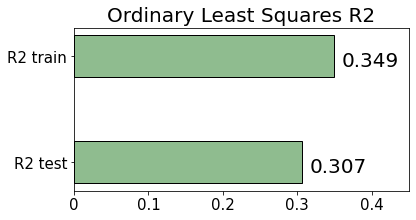

In [31]:
ols_r2_labels = ['R2 train', 'R2 test']
ols_r2_values = [R2_train, R2_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ols_r2_labels

x = np.arange(len(ols_r2_labels))
y = (ols_r2_values)

ax.set_yticks(x)
ax.set_yticklabels(ols_r2_labels,fontsize=15)
ax.set_title('Ordinary Least Squares R2', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ols_r2_values,fontsize=15)
ax.set_xlim(0, 0.45)

x_ticks = [0, 0.1, 0.2, 0.3, 0.4]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ols_r2_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+.01, i +.1, str(v), fontsize=20)
plt.show()


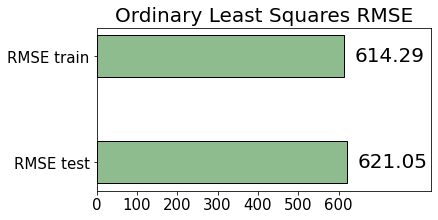

In [32]:
ols_rmse_labels = ['RMSE train', 'RMSE test']
ols_rmse_values = [RMSE_train, RMSE_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ols_rmse_labels

x = np.arange(len(ols_rmse_labels))
y = (ols_rmse_values)

ax.set_yticks(x)
ax.set_yticklabels(ols_rmse_labels,fontsize=15)
ax.set_title('Ordinary Least Squares RMSE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ols_rmse_values,fontsize=15)
ax.set_xlim(0, 830)

x_ticks = [0, 100, 200, 300, 400, 500, 600]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ols_rmse_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+25, i+.05, str(v), fontsize=20)
plt.show()

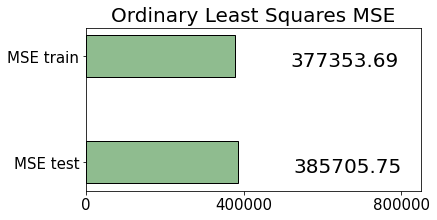

In [33]:
ols_mse_labels = ['MSE train', 'MSE test']
ols_mse_values = [MSE_train, MSE_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ols_mse_labels

x = np.arange(len(ols_mse_labels))
y = (ols_mse_values)

ax.set_yticks(x)
ax.set_yticklabels(ols_mse_labels,fontsize=15)
ax.set_title('Ordinary Least Squares MSE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ols_mse_values,fontsize=15)
ax.set_xlim(0, 850000)

x_ticks = [0, 400000, 800000]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ols_mse_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+140000, i+.1, str(v), fontsize=20)
plt.show()

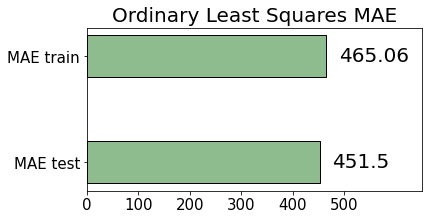

In [34]:
ols_mae_labels = ['MAE train', 'MAE test']
ols_mae_values = [MAE_train, MAE_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ols_mae_labels

x = np.arange(len(ols_mae_labels))
y = (ols_mae_values)

ax.set_yticks(x)
ax.set_yticklabels(ols_mae_labels,fontsize=15)
ax.set_title('Ordinary Least Squares MAE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ols_mae_values,fontsize=15)
ax.set_xlim(0, 650)

x_ticks = [0, 100, 200, 300, 400, 500]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ols_mae_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+25, i+.05, str(v), fontsize=20)
plt.show()

### Regresión Lasso

Vamos a correr una regresión Lasso para ver si el modelo mejora, tanto en sus métricas como en la cantidad de variables explicativas. <br>
Para esto, utilizaremos la técnica de Cross Validation para encontrar el mejor alpha para el conjunto de datos. 
- Dividimos el conjunto de datos en 5 folds, es decir, hacemos 5 entrenamientos, y se utilizan todos los valores de alpha que le indicamos manualmente.
- De los cinco entrenamientos que hace, el modelo saca un promedio del error cuadrático medio, y decide cuál es el mejor alpha para regularizar.
- Luego vamos a entrenar el modelo con ese alpha, que no es sino el valor del parámetro que minimiza el error cuadrático medio. 

In [35]:
# Lasso
X = data_final[['piscina_True', 'balcon_True', 
       'a_estrenar_True', 'parking_True',
       'property_type_house',
       'seguridad_True', 'subte_True',
       'metrobus_True', 'tren_True', "gimnasio_True","parque_True",
       'place_name_Almagro', 'place_name_Belgrano', 'place_name_Caballito',
       'place_name_Florida', 'place_name_La Lucila', 'place_name_Martínez',
       'place_name_Nuñez', 'place_name_Olivos', 'place_name_Palermo',
       'place_name_Saavedra', 'place_name_San Isidro',
       'place_name_Vicente López', 'place_name_Villa Crespo', 'rooms_nm',
       'surface_uncovered_nm',
       'place_name_house_Acassuso house',
       'place_name_house_Almagro house', 
       'place_name_house_Belgrano house',
       'place_name_house_Caballito house',
       'place_name_house_Florida house',
       'place_name_house_La Lucila house',
       'place_name_house_Martínez house', 
       'place_name_house_Nuñez house',
       'place_name_house_Olivos house',
       'place_name_house_Palermo house',
       'place_name_house_Saavedra house',
       'place_name_house_San Isidro house',
       'place_name_house_Vicente López house',
     'place_name_house_Villa Crespo house']]   
    
y = data_final.price_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 111)

lm_lasso = linear_model.LassoCV(alphas= [0.001,0.01,0.05, 0.06, 0.07, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3, 0.95,0.96, 0.97,1.0,2.0, 10.0, 15.0,30.0], 
                                  fit_intercept=True, normalize=False, cv=5, max_iter=1e4)

# hora le decimos que ajuste el modelo con los datos de entrenamiento.

model_cv_lasso = lm_lasso.fit(X_train, y_train)


In [36]:
best_alpha_lasso = model_cv_lasso.alpha_
best_alpha_lasso

0.1

El mejor alpha que encontramos es 0.1. Dada la ecuación de Lasso, este valor minimiza la función de costo. <br>
Ahora vamos a utilizar este alpha para entrenar el modelo.

In [37]:
model_lasso = linear_model.Lasso(alpha = best_alpha_lasso, fit_intercept = True, normalize = False)
model_fit_lasso = model_lasso.fit(X_train, y_train)

Imprimimos los coeficientes y el intercepto del modelo.

In [38]:
print(model_fit_lasso.coef_)
print(model_fit_lasso.intercept_)

[ 3.25574459e+02 -5.84208593e+00 -1.96595628e+01  1.49094415e+02
 -8.23998436e+02  7.92494855e+01 -5.87739253e+01 -2.25551172e+02
  1.03088537e+02  1.08924335e+02  1.07700974e+01 -4.29170991e+02
  3.44167063e+02 -1.95693133e+02 -2.26758137e+02  7.00237996e+02
  5.37562266e+02  1.90327196e+02  3.21801452e+02  3.88386810e+02
 -2.94255403e+02 -5.53952080e+01  4.18301902e+02 -9.19534025e+01
  1.20303427e+02 -1.15962431e+04 -5.06265860e+02  2.78287081e+02
  1.88386795e+02  1.04609704e+02 -2.38772182e+01 -2.84181393e+02
 -6.02748569e+02  4.89720647e+01 -4.74677248e+02  7.89257670e+01
  3.98341937e+01 -0.00000000e+00 -3.56290311e+02 -4.77311382e+01]
10837.469734686158


Parece haber varias variables que pierden total relevancia cuando aplicamos Lasso, por lo cual si usaramos este modelo quedarían descartadas.

Por último, analizamos las métricas obtenidas.

In [39]:
lasso_prediction_train = model_fit_lasso.predict(X_train)
lasso_prediction_test = model_fit_lasso.predict(X_test)

print("R2 Lasso con datos de entrenamiento: ", round(r2_score(y_train, lasso_prediction_train),3))
print("R2 Lasso con datos de testeo: ", round(r2_score(y_test, lasso_prediction_test),3))

print("RMSE Lasso con datos de entrenamiento: ", round(np.sqrt(mean_squared_error(y_train,lasso_prediction_train)),2))
print("RMSE Lasso con datos de testeo: ", round(np.sqrt(mean_squared_error(y_test, lasso_prediction_test)),2)) 

print("MAE Lasso con datos de enternamiento: ", round(eval_measures.meanabs(y_train, lasso_prediction_train),2))
print("MAE Lasso con datos de testeo: ", round(eval_measures.meanabs(y_test, lasso_prediction_test),2))

R2 Lasso con datos de entrenamiento:  0.348
R2 Lasso con datos de testeo:  0.321
RMSE Lasso con datos de entrenamiento:  614.52
RMSE Lasso con datos de testeo:  614.61
MAE Lasso con datos de enternamiento:  465.35
MAE Lasso con datos de testeo:  451.27


In [40]:
R2_lasso_train = round(r2_score(y_train, lasso_prediction_train),3)
R2_lasso_test = round(r2_score(y_test, lasso_prediction_test),3)

RMSE_lasso_train = round(np.sqrt(mean_squared_error(y_train,lasso_prediction_train)),2)
RMSE_lasso_test = round(np.sqrt(mean_squared_error(y_test, lasso_prediction_test)),2)

MSE_lasso_train = round(mean_squared_error(y_train,lasso_prediction_train),2)
MSE_lasso_test = round(mean_squared_error(y_test, lasso_prediction_test),2)

MAE_lasso_train = round(eval_measures.meanabs(y_train, lasso_prediction_train),2)
MAE_lasso_test = round(eval_measures.meanabs(y_test, lasso_prediction_test),2)

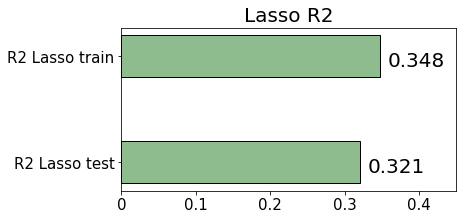

In [41]:
lasso_r2_labels = ['R2 Lasso train', 'R2 Lasso test']
lasso_r2_values = [R2_lasso_train, R2_lasso_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= lasso_r2_labels

x = np.arange(len(lasso_r2_labels))
y = (lasso_r2_values)

ax.set_yticks(x)
ax.set_yticklabels(lasso_r2_labels,fontsize=15)
ax.set_title('Lasso R2', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(lasso_r2_values,fontsize=15)
ax.set_xlim(0, 0.45)

x_ticks = [0, 0.1, 0.2, 0.3, 0.4]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = lasso_r2_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+.01, i +.1, str(v), fontsize=20)
plt.show()


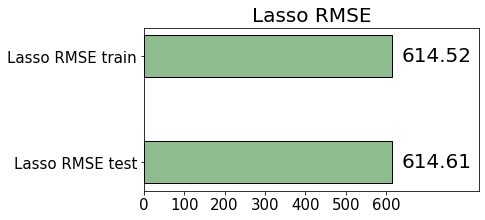

In [42]:
lasso_rmse_labels = ['Lasso RMSE train', 'Lasso RMSE test']
lasso_rmse_values = [RMSE_lasso_train, RMSE_lasso_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= lasso_rmse_labels

x = np.arange(len(lasso_rmse_labels))
y = (lasso_rmse_values)

ax.set_yticks(x)
ax.set_yticklabels(lasso_rmse_labels,fontsize=15)
ax.set_title('Lasso RMSE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(lasso_rmse_values,fontsize=15)
ax.set_xlim(0, 830)

x_ticks = [0, 100, 200, 300, 400, 500, 600]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = lasso_rmse_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+25, i+.05, str(v), fontsize=20)
plt.show()

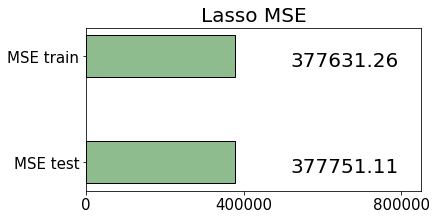

In [43]:
lasso_mse_labels = ['MSE train', 'MSE test']
lasso_mse_values = [MSE_lasso_train, MSE_lasso_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= lasso_mse_labels

x = np.arange(len(lasso_mse_labels))
y = (lasso_mse_values)

ax.set_yticks(x)
ax.set_yticklabels(lasso_mse_labels,fontsize=15)
ax.set_title('Lasso MSE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(lasso_mse_values,fontsize=15)
ax.set_xlim(0, 850000)

x_ticks = [0, 400000, 800000]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = lasso_mse_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+140000, i+.1, str(v), fontsize=20)
plt.show()

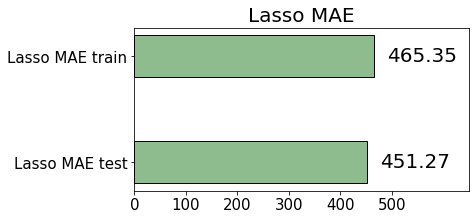

In [44]:
lasso_mae_labels = ['Lasso MAE train', 'Lasso MAE test']
lasso_mae_values = [MAE_lasso_train, MAE_lasso_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= lasso_mae_labels

x = np.arange(len(lasso_mae_labels))
y = (lasso_mae_values)

ax.set_yticks(x)
ax.set_yticklabels(lasso_mae_labels,fontsize=15)
ax.set_title('Lasso MAE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(lasso_mae_values,fontsize=15)
ax.set_xlim(0, 650)

x_ticks = [0, 100, 200, 300, 400, 500]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = lasso_mae_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+25, i+.05, str(v), fontsize=20)
plt.show()

Como podemos ver, tanto el R2 (baja) como el MSE (sube) empeoran cuando pasamos a los datos de testeo.

### Regresión Ridge

Repetimos el mismo proceso que con Lasso. <br>
De la misma forma, utilizaremos la técnica de Cross Validation para encontrar el mejor alpha para el conjunto de datos. <br>
Dividimos el conjunto de datos en 5 folds, es decir, hacemos 5 entrenamientos, y se utilizan todos los valores de alpha que le indicamos manualmente. <br>
De los cinco entrenamientos que hace, el modelo saca un promedio del error cuadrático medio, y decide cuál es el mejor alpha para regularizar. <br>
Luego vamos a entrenar el modelo con ese alpha, que no es sino el valor del parámetro que minimiza el error cuadrático medio.


In [45]:
# Ridge

X = data_final[['piscina_True', 'balcon_True', 
       'a_estrenar_True', 'parking_True',
       'property_type_house',
       'seguridad_True', 'subte_True',
       'metrobus_True', 'tren_True', "gimnasio_True","parque_True",
       'place_name_Almagro', 'place_name_Belgrano', 'place_name_Caballito',
       'place_name_Florida', 'place_name_La Lucila', 'place_name_Martínez',
       'place_name_Nuñez', 'place_name_Olivos', 'place_name_Palermo',
       'place_name_Saavedra', 'place_name_San Isidro',
       'place_name_Vicente López', 'place_name_Villa Crespo', 'rooms_nm',
       'surface_uncovered_nm',
       'place_name_house_Acassuso house',
       'place_name_house_Almagro house', 
       'place_name_house_Belgrano house',
       'place_name_house_Caballito house',
       'place_name_house_Florida house',
       'place_name_house_La Lucila house',
       'place_name_house_Martínez house', 
       'place_name_house_Nuñez house',
       'place_name_house_Olivos house',
       'place_name_house_Palermo house',
       'place_name_house_Saavedra house',
       'place_name_house_San Isidro house',
       'place_name_house_Vicente López house',
     'place_name_house_Villa Crespo house']]   
    
y = data_final.price_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 110)

lm_ridge = linear_model.RidgeCV(alphas= [0.1, 0.3, 0.4,0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 3.4, 5, 10.0], 
                                   fit_intercept=True, normalize=False, cv=10)

model_cv_ridge = lm_ridge.fit(X_train, y_train)

In [46]:
best_alpha_ridge = model_cv_ridge.alpha_
best_alpha_ridge

0.1

El mejor alpha que encontramos también es 0.1. Dada la ecuación de Ridge, este valor minimiza la función de costo. <br>
Ahora vamos a utilizar este alpha para entrenar el modelo.

In [47]:
model_ridge = linear_model.Ridge(alpha = best_alpha_ridge, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)

Analizamos los coeficientes obtenidos. A diferencia del Lasso, ningún coeficiente se hace 0. Es decir, el modelo no descarta ninguna variable.

In [48]:
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)

[ 3.21291157e+02 -1.95076976e+01 -4.03264682e+01  1.91018845e+02
 -8.85366659e+02  7.30758812e+01 -6.69546600e+01 -2.11523515e+02
  1.36077373e+02  1.21503804e+02 -1.49497136e+01 -3.89086572e+02
  3.83797942e+02 -1.56314913e+02 -2.71354742e+02  7.32637288e+02
  5.89054199e+02  2.41190449e+02  4.34896084e+02  4.52458062e+02
 -2.45436094e+02 -3.21065053e+01  4.65372539e+02 -7.83620551e+01
  1.67322789e+03 -1.02853309e+04 -5.01885076e+02  2.81777844e+02
  3.59489873e+02  1.53975362e+02  8.49375318e+01 -2.71629568e+02
 -5.69383531e+02  1.78557446e+02 -5.25753407e+02  9.55641721e+00
  1.11463429e+02  4.83649247e+01 -2.95851602e+02  5.10136989e+01]
9871.924765961825


Por último, nos quedamos con las métricas de Ridge

In [49]:
ridge_prediction_train = model_fit_ridge.predict(X_train)
ridge_prediction_test = model_fit_ridge.predict(X_test)

print("R2 Ridge con datos de entrenamiento: ", round(r2_score(y_train, ridge_prediction_train),3))
print("R2 Ridge con datos de testeo: ", round(r2_score(y_test, ridge_prediction_test),3))

print("RMSE Ridge con datos de entrenamiento: ", round(np.sqrt(mean_squared_error(y_train, ridge_prediction_train)),2))
print("RMSE Ridge con datos de testeo: ", round(np.sqrt(mean_squared_error(y_test, ridge_prediction_test)),2)) 

print("MAE Ridge con datos de entrenamiento: ", round(eval_measures.meanabs(y_train, ridge_prediction_train),2))
print("MAE Ridge con datos de testeo: ", round(eval_measures.meanabs(y_test, ridge_prediction_test),2))

R2 Ridge con datos de entrenamiento:  0.361
R2 Ridge con datos de testeo:  0.292
RMSE Ridge con datos de entrenamiento:  606.01
RMSE Ridge con datos de testeo:  635.34
MAE Ridge con datos de entrenamiento:  459.45
MAE Ridge con datos de testeo:  477.32


In [50]:
R2_ridge_train = round(r2_score(y_train, ridge_prediction_train),3)
R2_ridge_test = round(r2_score(y_test, ridge_prediction_test),3)

RMSE_ridge_train = round(np.sqrt(mean_squared_error(y_train,ridge_prediction_train)),2)
RMSE_ridge_test = round(np.sqrt(mean_squared_error(y_test, ridge_prediction_test)),2)

MSE_ridge_train = round(mean_squared_error(y_train,ridge_prediction_train),2)
MSE_ridge_test = round(mean_squared_error(y_test, ridge_prediction_test),2)

MAE_ridge_train = round(eval_measures.meanabs(y_train, ridge_prediction_train),2)
MAE_ridge_test = round(eval_measures.meanabs(y_test, ridge_prediction_test),2)

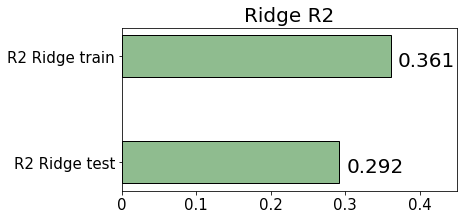

In [51]:
ridge_r2_labels = ['R2 Ridge train', 'R2 Ridge test']
ridge_r2_values = [R2_ridge_train, R2_ridge_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ridge_r2_labels

x = np.arange(len(ridge_r2_labels))
y = (ridge_r2_values)

ax.set_yticks(x)
ax.set_yticklabels(ridge_r2_labels,fontsize=15)
ax.set_title('Ridge R2', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ridge_r2_values,fontsize=15)
ax.set_xlim(0, 0.45)

x_ticks = [0, 0.1, 0.2, 0.3, 0.4]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ridge_r2_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+.01, i +.1, str(v), fontsize=20)
plt.show()

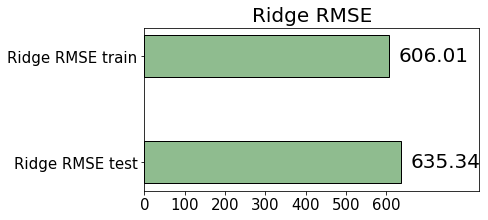

In [52]:
ridge_rmse_labels = ['Ridge RMSE train', 'Ridge RMSE test']
ridge_rmse_values = [RMSE_ridge_train, RMSE_ridge_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ridge_rmse_labels

x = np.arange(len(ridge_rmse_labels))
y = (ridge_rmse_values)

ax.set_yticks(x)
ax.set_yticklabels(ridge_rmse_labels,fontsize=15)
ax.set_title('Ridge RMSE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ridge_rmse_values,fontsize=15)
ax.set_xlim(0, 830)

x_ticks = [0, 100, 200, 300, 400, 500, 600]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ridge_rmse_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+25, i+.05, str(v), fontsize=20)
plt.show()

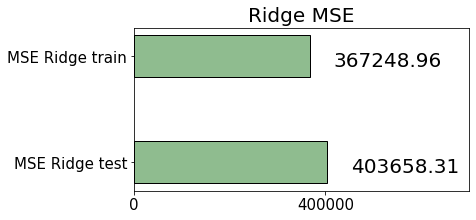

In [53]:
ridge_mse_labels = ['MSE Ridge train', 'MSE Ridge test']
ridge_mse_values = [MSE_ridge_train, MSE_ridge_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ridge_mse_labels

x = np.arange(len(ridge_mse_labels))
y = (ridge_mse_values)

ax.set_yticks(x)
ax.set_yticklabels(ridge_mse_labels,fontsize=15)
ax.set_title('Ridge MSE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ridge_mse_values,fontsize=15)
ax.set_xlim(0, 700000)

x_ticks = [0, 400000]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ridge_mse_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+50000, i+.1, str(v), fontsize=20)
plt.show()

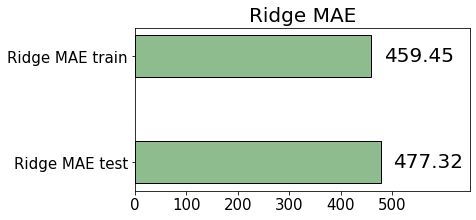

In [54]:
ridge_mae_labels = ['Ridge MAE train', 'Ridge MAE test']
ridge_mae_values = [MAE_ridge_train, MAE_ridge_test]

fig = plt.figure(figsize = (6, 3))
ax = plt.axes()
width=0.4
labels= ridge_mae_labels

x = np.arange(len(ridge_mae_labels))
y = (ridge_mae_values)

ax.set_yticks(x)
ax.set_yticklabels(ridge_mae_labels,fontsize=15)
ax.set_title('Ridge MAE', fontsize = 20)

ax.set_xticks(y)
ax.set_xticklabels(ridge_mae_values,fontsize=15)
ax.set_xlim(0, 650)

x_ticks = [0, 100, 200, 300, 400, 500]
plt.xticks(ticks = x_ticks, labels = x_ticks)

bars = ax.barh(x, y, width, data = ridge_mae_values, color='darkseagreen',edgecolor="black", linewidth=1)
ax.invert_yaxis()

for i, v in enumerate(y):
    ax.text(v+25, i+.05, str(v), fontsize=20)
plt.show()

In [55]:
# data_final.to_csv('data_final.csv')

In [56]:
resultados = {
        'Sin regularizar':  [R2_train, R2_test, RMSE_train, RMSE_test, MAE_train, MAE_test],
        'Lasso': [R2_lasso_train, R2_lasso_test, RMSE_lasso_train, RMSE_lasso_test, MAE_lasso_train, MAE_lasso_test],
        'Ridge': [R2_ridge_train, R2_ridge_test, RMSE_ridge_train, RMSE_ridge_test, MAE_ridge_train, MAE_ridge_test]
        }

resultados = pd.DataFrame(resultados, index=['R2 train','R2 test','RMSE train','RMSE test','MAE train',"MAE test"])

print (resultados)


            Sin regularizar    Lasso    Ridge
R2 train              0.349    0.348    0.361
R2 test               0.307    0.321    0.292
RMSE train          614.290  614.520  606.010
RMSE test           621.050  614.610  635.340
MAE train           465.060  465.350  459.450
MAE test            451.500  451.270  477.320


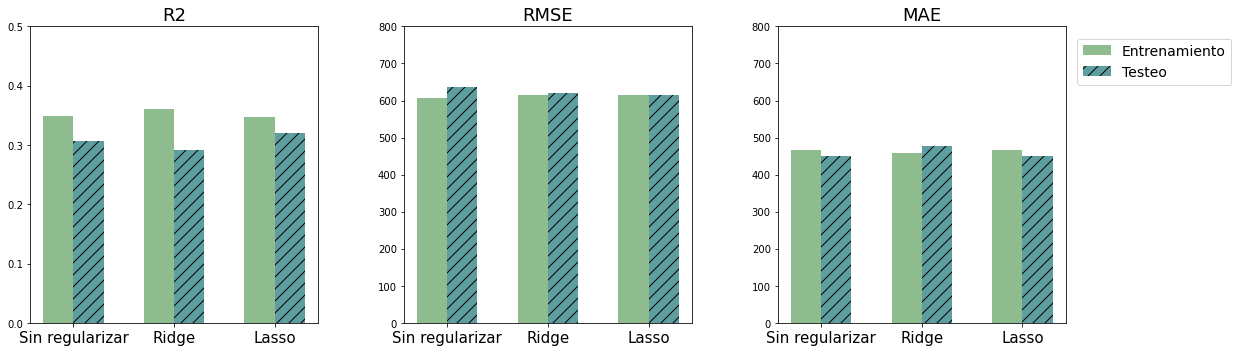

In [57]:
labels = ['Sin regularizar', 'Ridge', 'Lasso']

R2_train_1 = {R2_train,  R2_ridge_train, R2_lasso_train}
R2_test_2 = {R2_test,  R2_ridge_test, R2_lasso_test}

MSE_train_1 = {RMSE_train,  RMSE_ridge_train, RMSE_lasso_train}
MSE_test_2 = {RMSE_test,  RMSE_ridge_test, RMSE_lasso_test}

MAE_train_1 = {MAE_train,  MAE_ridge_train, MAE_lasso_train}
MAE_test_2 = {MAE_test,  MAE_ridge_test, MAE_lasso_test}

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('R2', fontsize=18)
plt.bar(x-width/2, R2_train_1, width, label='Entrenamiento', color="darkseagreen")
plt.bar(x+width/2, R2_test_2, width, label='Testeo', hatch='//', color = "cadetblue")
plt.xticks([0,1,2], labels, fontsize=15)
plt.ylim((0, 0.5))


plt.subplot(1,3,2)
plt.title('RMSE', fontsize=18)
plt.bar(x-width/2, MSE_train_1, width,  color= "darkseagreen")
plt.bar(x+width/2, MSE_test_2, width,hatch='//', color = "cadetblue")
plt.xticks([0,1,2], labels, fontsize=15)
plt.ylim((0, 800))

plt.subplot(1,3,3)
plt.title('MAE', fontsize=18)
plt.bar(x-width/2, MAE_train_1, width, color="darkseagreen")
plt.bar(x+width/2, MAE_test_2, width, hatch='//', color = "cadetblue")
plt.xticks([0,1,2], labels, fontsize=15)
plt.ylim((0, 800))

plt.figlegend(loc='upper right', ncol=1, labelspacing=0.5, fontsize=14, bbox_to_anchor=(1.15, 0.9))
plt.tight_layout(w_pad=6) 
plt.show()